<a href="https://colab.research.google.com/github/juergenlandauer/FoundationModelsArchaeology/blob/main/Experiment_3_Hillforts_LiDAR/Gemini_hillforts_Lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic site detection in satellite and LiDAR images with Gemini by Google

Author: Juergen Landauer (juergen AT landauer-ai.de)

To start, first go to the "Input parameters" section below and review or (optionally) adjust parameters. Then run the entire Notebook by choosing Runtime->Run all in the menu above.


### Set up your API key and install the Gemini Python SDK

To access Gemini, you need to provide your Google Gemini API key. Follow these steps:

- register with Google (also works with your Gmail account)
- Login here and get your API key: (https://aistudio.google.com/apikey)
- Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
- Store Google API key under the name `GOOGLE_API_KEY`.

Details are found here: https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb.

In [ ]:
!pip install -Uq google-generativeai
!pip install -Uq rvt-py rasterio

In [ ]:
from google import genai
from google.colab import userdata
from google.genai import types

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

client = genai.Client(api_key=GOOGLE_API_KEY)

# Input parameters

Review all parameters in this section and (optionally) adjust them on the right side. For example, you can upload your own input zip file by providing an URL.

#### Demo with castles from Bavaria (Germany) in Satellite imagery from Microsoft Bing
Feel free to replace this with your own imagery by providing a download URL (e.g. from Google Drive)

Note that the ZIP file must contain two sub-folders called "sites" and "nonsites", resp. Each folder must then contain images of sites or samples of other landscape (non-sites)

Hillforts Lidar

In [ ]:
INPUT_ZIP_URL_NONSITES = 'https://www.dropbox.com/scl/fi/tkar49txfsaz8w7xcfweu/EN_nonforts_1000_GeoTiff_raw.zip?rlkey=k4oymy32v0axue9d158jkpr5o&st=vyp0m12o&dl=0'
INPUT_ZIP_URL_SITES    = 'https://www.dropbox.com/scl/fi/kv223sslzfgtcctqai390/EN_hillforts_300_GeoTiff_raw.zip?rlkey=lcjh9kzdpe0q2w943z52kvtyy&st=9837ca2c&dl=0'

#### The text 'prompt' sent to the Foundation Model.

Play with different variations of the text and don't forget to include the object type you are looking for.

In [ ]:
# Hillforts
PROMPT = """
You are analyzing a LiDAR image that may contain archaeological features from England, such as enclosures, hillforts, or other ancient man-made structures.

Important Note: The majority of LiDAR images will likely contain no archaeological features at all.
Therefore, avoid making detections unless there is strong, high-confidence evidence.

For each distinct object or feature only if confidently detected, return the following in JSON format:

Object Type — classify the object (e.g., enclosure, hillfort, natural formation, unknown).

Confidence Score — your estimated probability (%) that the classification is correct.

Bounding Box — provide coordinates in the format [x_min, y_min, x_max, y_max]. Make sure the bounding box tightly encompasses the object.

Reason - textually explain why you think the given object is found.

If no archaeological features are confidently detected, return an empty list

"""

The text response from the AI is sometimes ambiguous. If you only (or "strictly") want to see certain types of responses, then keep this to True and provide a list of keywords you want to see in the output. Make sure you do not mess up the list syntax.

In [ ]:
STRICT_RESPONSE_FILTERING = True # @param ['True', 'False']

#FILTER_KEYWORDS = ["temple", "moat"]  # @param {"allow-input":true}

#FILTER_KEYWORDS = ["castle", "ruin", "enclosure", "hillfort"]  # @param {"allow-input":true}

FILTER_KEYWORDS = ["enclosure", "hillfort"]  # @param {"allow-input":true}


Here we define the model we are using. Usually it is not required to change this.

In [ ]:
MODEL_ID="gemini-2.0-flash" # @param ["gemini-2.5-flash-preview-05-20","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

# here we determine the RPM of these models (RPM = Requests Per Minute)
if "lite" in MODEL_ID:           RPM = 30
elif "exp" in MODEL_ID: RPM = 10
elif "preview" in MODEL_ID:      RPM = 10
else:                            RPM = 15 # "flash"

RPM

15

In [ ]:
# if you have a paid subscription, the RPM can be much higher.
# in that case, uncomment this line please
# RPM = 1000

In case you encounter performance issues, consider setting RESIZE to True, as it halves each image dimension

In [ ]:
RESIZE = False # @param ['True', 'False']

## We load the data and unzip it into the directory 'input'

In [ ]:
!rm -rf input output file.zip
!mkdir -p input/nonsites input/sites
!wget -O file.zip "$INPUT_ZIP_URL_NONSITES"
!unzip -q file.zip -d input/nonsites
!wget -O file.zip "$INPUT_ZIP_URL_SITES"
!unzip -q file.zip -d input/sites

--2025-07-10 14:41:49--  https://www.dropbox.com/scl/fi/5vaxgrk3h5urd2khaaarc/DEM_NonForts_EN_100.zip?rlkey=dfqn5ouzsy1on6kz4qbe8elrp&st=ipc1wqfj&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b1660aef45781022967db9678.dl.dropboxusercontent.com/cd/0/inline/CtPla5fj4GM1SldKaeY12NdcnxNGxqdz5eLTnbpkdWnAmFpOnzxIuKkbDv0YiIOlNxj_mMlDDLbK-VM5z7R7_mE_JuYLHacDi6UZ7GTBz4LBLQL7y9pWXOkcRS672WPqr18/file# [following]
--2025-07-10 14:41:50--  https://uc5b1660aef45781022967db9678.dl.dropboxusercontent.com/cd/0/inline/CtPla5fj4GM1SldKaeY12NdcnxNGxqdz5eLTnbpkdWnAmFpOnzxIuKkbDv0YiIOlNxj_mMlDDLbK-VM5z7R7_mE_JuYLHacDi6UZ7GTBz4LBLQL7y9pWXOkcRS672WPqr18/file
Resolving uc5b1660aef45781022967db9678.dl.dropboxusercontent.com (uc5b1660aef45781022967db9678.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6030:15::a2

### we now import some libraries

In [ ]:
import numpy as np
import os
from osgeo import gdal
import cv2 as cv
import PIL.Image
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import time
from tqdm import tqdm
from google.colab import files as colabfiles
import json
import random
import io
from PIL import Image, ImageDraw, ImageColor

### Some utility functions we use

In [ ]:
# remove all pixels below -10 and above 1000-min
def remove_outliers(image:np.ndarray):
    if np.isnan(image).sum() > 0:
        print ("NAN!", np.isnan(image).sum() )
    min_zero = image[image>-10].min()
    image[image<=-10] = min_zero
    # do we still have extremal values?
    mymax = np.max(image)
    mymin = np.min(image)
    if mymax-mymin>1000:
        print ("outlier removal:", mymax)
        hi = np.percentile(image, 99).min()
        image[image>1000+mymin] = hi
    return image

In [ ]:
import rvt.vis
def preprocessSnippetHillshade(image: np.array):
    image = remove_outliers(image)

    pixels = rvt.vis.hillshade(
        dem=np.squeeze(image), # remove axis...
                sun_azimuth=315,
                sun_elevation=45,
                resolution_x=1.,
                resolution_y=1.,
                ve_factor=3, # was 2 !!!!!!
                #no_data=dem_no_data
            ) # output is float32
    #pixels = np.nan_to_num(pixels, copy=True, nan=0.0, posinf=None, neginf=None)# remove NaN
    pixels = pixels[np.newaxis,...] # and add axis again

    return pixels

In [ ]:
from osgeo import gdal
#import rvt.default
import rvt.vis

def preprocessSnippetSLRM(image: np.ndarray):
    image = remove_outliers(image)
    image = rvt.vis.slrm(dem=np.squeeze(image), # remove axis...
                radius_cell=10,
                ve_factor=1,
                no_data=None
    )
    #image = image[np.newaxis,...] # and add axis again
    mymin, mymax = image.min(), image.max()
    image = np.interp(image, (mymin, mymax), (0, 255)).astype(np.uint8)
    return image

In [ ]:
import rasterio as rio
def read_hillshade(fpath):
  with rio.open(fpath) as t:
     img = t.read().squeeze()
  img = (preprocessSnippetHillshade(img)*256).astype(np.uint8)
  #img = (preprocessSnippetSLRM(img)).astype(np.uint8)
  pilimg = PIL.Image.fromarray(img.squeeze()).convert('RGB')
  return pilimg

In [ ]:
# function to read the images as PIL
def read_pil(fpath):
  pilimg = PIL.Image.open(fpath)
  return pilimg

In [ ]:
# modified from https://github.com/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb
# function to plot bounding boxes on images
def plot_bounding_boxes(img, noun_phrases_and_positions):
    width, height = img.size
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, prob, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color
        color = 'green'
        if prob >0.85: color = 'red'
        else: color = 'blue'

        wid = 4
        for k in FILTER_KEYWORDS:
          if k in noun_phrase:
            color = 'yellow'
            wid = 8

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Ensure x1 <= x2 and y1 <= y2
        abs_x1, abs_x2 = sorted([abs_x1, abs_x2])  # Sort x-coordinates
        abs_y1, abs_y2 = sorted([abs_y1, abs_y2])  # Sort y-coordinates

        # Draw the bounding box
        draw.rectangle( ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=wid)

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# process folder

In [ ]:
sites = sorted(glob('./input/sites/**/*.*', recursive=True))
nonsites = sorted(glob('./input/nonsites/**/*.*', recursive=True))
len(sites), len(nonsites)

(100, 100)

In [ ]:
# uncomment below if you want to try just a small sample of MAX_N for each class
import random
MAX_Sites = 20
MAX_Nonsites = 10

#sites = random.sample(sites, MAX_Sites)
#nonsites = random.sample(nonsites, MAX_Nonsites)

#sites = sites[0:MAX_Sites]
#nonsites = nonsites[0:MAX_Nonsites]

In [ ]:
len(sites), len(nonsites)

(20, 10)

In [ ]:
# define the Gemini output format of a 'Detection'
from pydantic import BaseModel, TypeAdapter
class Detection(BaseModel):
  detection_type: str
  probability: float
  bbox: list[int]
  reason: str

# Define the schema for a list of Detection objects
list_detection_schema = {
    "type": "array",
    "items": Detection.model_json_schema()
}

#### Visualization function selection


In [ ]:
visualizeFN = read_hillshade
#visualizeFN = read_pil

## Processing all files with Gemini

In [ ]:
!rm -rf output
!mkdir output output/FN output/TP output/FP output/TN

In [ ]:
# configure parameters
TEMPERATURE = 1.0
#TEMPERATURE = 0.7
#TEMPERATURE = 0.3

In [ ]:
files = sites + nonsites
#files = nonsites

  0%|          | 0/30 [00:00<?, ?it/s]

________________________________________________________
./input/sites/EN0001_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 85.0,
    "bbox": [
      150,
      215,
      650,
      600
    ],
    "reason": "The image shows a clearly defined raised area enclosed by a bank or ditch. This morphology is characteristic of hillforts, especially given the location of the image in England."
  }
]
hillfort 85.0 [150, 215, 650, 600]


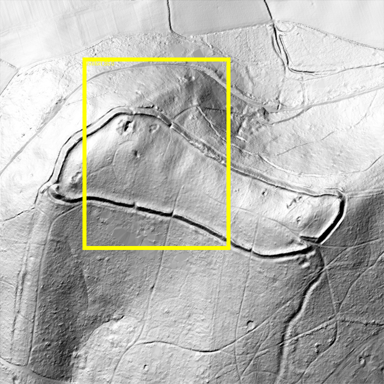

TP, FP, FN, TN= 1 0 0 0 ( 1 )


  3%|▎         | 1/30 [00:04<02:19,  4.80s/it]

________________________________________________________
./input/sites/EN0002_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 95.0,
    "bbox": [
      171,
      138,
      438,
      459
    ],
    "reason": "The LiDAR image reveals a distinct, elevated, oval-shaped feature with surrounding ditches and ramparts, characteristic of a hillfort. The consistent shape and defined boundaries suggest a man-made structure for defensive purposes."
  }
]
hillfort 95.0 [171, 138, 438, 459]


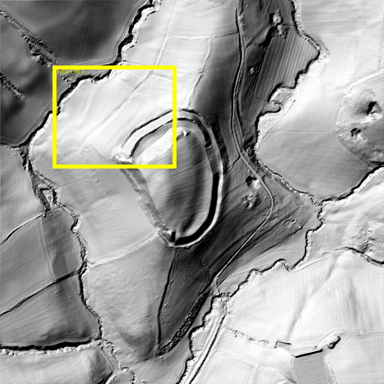

TP, FP, FN, TN= 2 0 0 0 ( 2 )


  7%|▋         | 2/30 [00:09<02:07,  4.57s/it]

________________________________________________________
./input/sites/EN0003_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 85.0,
    "bbox": [
      195,
      224,
      368,
      404
    ],
    "reason": "The multiple concentric rings and elevated position suggest the presence of a hillfort, a common type of ancient fortification in England."
  },
  {
    "detection_type": "enclosure",
    "probability": 70.0,
    "bbox": [
      73,
      234,
      194,
      346
    ],
    "reason": "The incomplete rectangular shape with raised edges is indicative of an enclosure, possibly for livestock or agricultural purposes. The visibility of the banks provides evidence for this interpretation."
  }
]
hillfort 85.0 [195, 224, 368, 404]
enclosure 70.0 [73, 234, 194, 346]


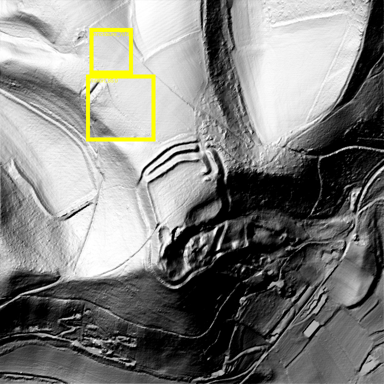

TP, FP, FN, TN= 3 0 0 0 ( 3 )


 10%|█         | 3/30 [00:13<02:00,  4.48s/it]

________________________________________________________
./input/sites/EN0004_0.0_768_768.tif -- response: [
  {
    "detection_type": "enclosure",
    "probability": 85.0,
    "bbox": [
      333,
      258,
      507,
      557
    ],
    "reason": "The LiDAR image reveals a clear, semi-circular raised earthwork, likely forming an enclosure. The consistent elevation change along the perimeter suggests a man-made feature rather than a natural one."
  }
]
enclosure 85.0 [333, 258, 507, 557]


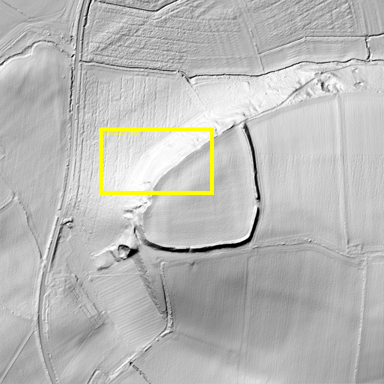

TP, FP, FN, TN= 4 0 0 0 ( 4 )


 13%|█▎        | 4/30 [00:17<01:49,  4.20s/it]

________________________________________________________
./input/sites/EN0005_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 90.0,
    "bbox": [
      276,
      153,
      413,
      303
    ],
    "reason": "Appears to be a circular enclosure with multiple ramparts and a clearly defined central area, indicative of a hillfort."
  }
]
hillfort 90.0 [276, 153, 413, 303]


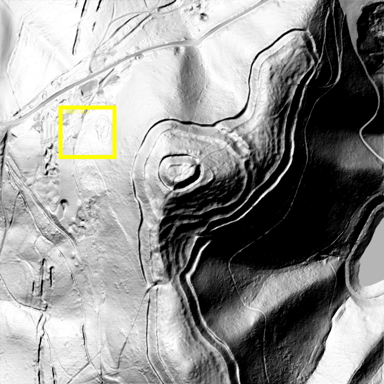

TP, FP, FN, TN= 5 0 0 0 ( 5 )


 17%|█▋        | 5/30 [00:21<01:41,  4.04s/it]

________________________________________________________
./input/sites/EN0006_0.0_768_768.tif -- response: []


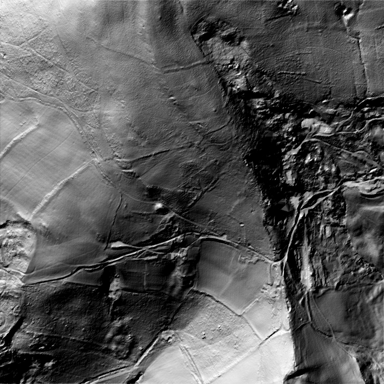

TP, FP, FN, TN= 5 0 1 0 ( 6 )


 20%|██        | 6/30 [00:24<01:28,  3.68s/it]

________________________________________________________
./input/sites/EN0007_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 95.0,
    "bbox": [
      103,
      275,
      757,
      500
    ],
    "reason": "The LiDAR image shows a clear oval-shaped earthwork with a defined ditch and bank structure. The morphology and size are consistent with the characteristics of a hillfort."
  }
]
hillfort 95.0 [103, 275, 757, 500]


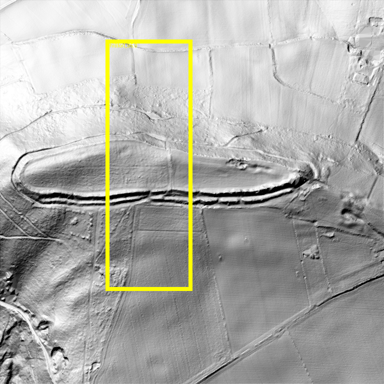

TP, FP, FN, TN= 6 0 1 0 ( 7 )


 23%|██▎       | 7/30 [00:27<01:25,  3.73s/it]

________________________________________________________
./input/sites/EN0008_0.0_768_768.tif -- response: []


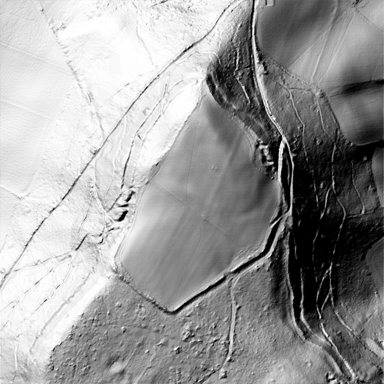

TP, FP, FN, TN= 6 0 2 0 ( 8 )


 27%|██▋       | 8/30 [00:30<01:15,  3.45s/it]

________________________________________________________
./input/sites/EN0009_0.0_768_768.tif -- response: []


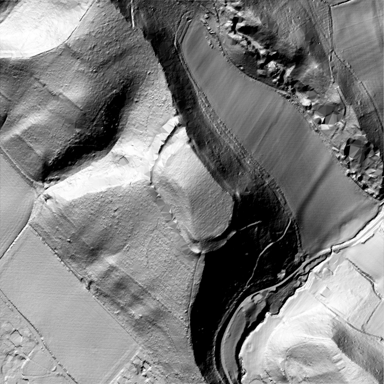

TP, FP, FN, TN= 6 0 3 0 ( 9 )


 30%|███       | 9/30 [00:33<01:07,  3.20s/it]

________________________________________________________
./input/sites/EN0010_0.0_768_768.tif -- response: [
  {
    "detection_type": "hillfort",
    "probability": 95.0,
    "bbox": [
      149,
      127,
      649,
      508
    ],
    "reason": "The LiDAR image reveals a distinct circular enclosure with multiple concentric ditches and ramparts, a common feature of Iron Age hillforts in England. The structure's prominent position on a hilltop further supports this identification."
  }
]
hillfort 95.0 [149, 127, 649, 508]


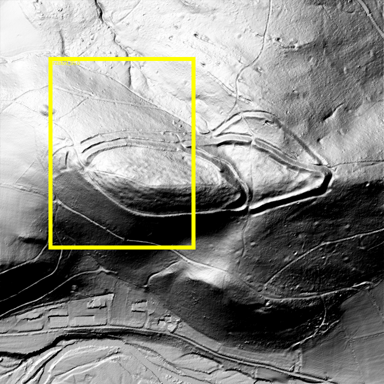

TP, FP, FN, TN= 7 0 3 0 ( 10 )


 33%|███▎      | 10/30 [00:39<01:18,  3.95s/it]


ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

In [ ]:
with open('./output/phrases.txt', 'w') as docfile:
  TP, FP, FN, TN = 0, 0, 0, 0

  for fpath in tqdm(files):
      img = visualizeFN(fpath)
      if RESIZE:
            new_size = (img.width // 2, img.height // 2)
            img = img.resize(new_size)

      #img = img.convert('L')
      img.save('temp.png')

      with open('temp.png', 'rb') as f:
        image_bytes = f.read()

      # Construct the contents list with proper part structure
      contents = [
        PROMPT,
        types.Part.from_bytes(
        data=image_bytes,
        mime_type='image/png',),
          #{'text': PROMPT},  # Text part for the prompt
      ]

      retries = 20 # Number of retries
      for attempt in range(retries):
          try:
              response = client.models.generate_content(model = MODEL_ID,
                  contents = contents,
                  config={'response_mime_type': 'application/json',
                          'response_schema': list_detection_schema,
                          'temperature' : TEMPERATURE,
                  },
                  #request_options={'timeout': 10}
              )
              break # If successful, break the retry loop
          except Exception as e:
              if e.code == 503 and attempt < retries - 1:
                  print(f"ServerError 503: Model overloaded. Retrying in 10 seconds (Attempt {attempt + 1}/{retries})...")
                  time.sleep(10)
              else:
                  print ("Error==>",e)
                  raise # Re-raise the exception if not a 503 error or no retries left

      print('________________________________________________________')
      print(fpath, "-- response:", response.text)

      objects = json.loads(response.text)

      # results visualization
      img = visualizeFN(fpath)
      phrases_boxes = []
      for item in objects: # for each detection
        if 'probability' in item:
            prob = item['probability']
        else: prob = 0.
        #if prob < 0.9: continue # OPTIONAL: filter for percentage
        detection_type = item['detection_type']
        reason = item['reason']
        if STRICT_RESPONSE_FILTERING and any(element in detection_type for element in FILTER_KEYWORDS):
            bbox = item['bbox']
            print (detection_type, prob, bbox)
            phrases_boxes += [(detection_type+"_"+str(prob), float(prob), bbox)]

      if phrases_boxes != []: # anything found?
        plot_bounding_boxes(img, noun_phrases_and_positions=phrases_boxes)
        if 'nonsites' in fpath: FP += 1;p="FP"
        else:                   TP += 1;p="TP"
      else: # nothing found
        if 'nonsites' in fpath: TN += 1;p="TN"
        else:                   FN += 1;p="FN"

      filename = Path(fpath).name
      img.save(Path('output')/Path(p)/filename)
      display(img.resize(size=(384, 384)))
      docfile.write(filename + ":" + str(objects) + os.linesep)
      print("TP, FP, FN, TN=", TP, FP, FN, TN, "(",TP+FN,")")
      time.sleep(60//RPM + 0.5) # sleep to meet RPM limit (requests per minute)

In [ ]:
F1 = 2*TP/(2*TP+FP+FN)
print (TP, FP, FN, TN)
print ("TPR=", TP/len(sites), "FPR=", FP/len(nonsites))
print ("********* F1:", F1, " *************")

with open('./output/phrases.txt', 'a') as docfile:
  docfile.write(f"---RESULTS------{os.linesep}")
  docfile.write(f"TP, FP, FN, TN={TP}, {FP}, {FN}, {TN}{os.linesep}")
  docfile.write(f"F1={F1}{os.linesep}")

### Export results for download
We now open a file download dialog for the output.zip. Simply store the output in your local computer. Done :-)

output.zip contains all images with bounding box annotations and a file phrases.txt containing the original response from Gemini.



In [ ]:
!zip -r output.zip output

In [ ]:
colabfiles.download('output.zip')